In [1]:
import numpy as np
import os
import h5py
import tables
from scipy.io import loadmat

from keras.preprocessing import image
from utils.angles import bit2deg, deg2bit

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
!nvidia-smi

Thu Mar  8 21:16:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:04:00.0 Off |                    0 |
| N/A   55C    P0    73W / 149W |  10964MiB / 11439MiB |     60%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:05:00.0 Off |                    0 |
| N/A   53C    P0   153W / 149W |  10944MiB / 11439MiB |    100%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
def train_val_split(x, y, val_split=0.2):

    n_samples = x.shape[0]

    shuffled_samples = np.random.choice(n_samples, n_samples, replace=False)
    n_train = int((1-val_split)*n_samples)
    train_samples = shuffled_samples[0:n_train]
    val_samples = shuffled_samples[n_train:]

    x_train, y_train = x[train_samples], y[train_samples]
    x_val, y_val = x[val_samples], y[val_samples]
    
    return x_train, y_train, x_val, y_val

def merge_all_classes(data):
    
    images = []
    angles = []
    for obj_key in data.keys(): 
        images.append(np.asarray(data[obj_key]['images']))
        azimuth_bit = np.asarray(data[obj_key]['azimuth_bit'])
        elevation_bit = np.asarray(data[obj_key]['elevation_bit'])
        tilt_bit = np.asarray(data[obj_key]['tilt_bit'])
        angles.append(np.hstack([azimuth_bit, elevation_bit, tilt_bit]))
    
    images = np.vstack(images)
    angles = np.vstack(angles)
    
    return images, angles

In [4]:
train_test_data_db = h5py.File('../data/pascal_imagenet_train_test.h5', 'r')

train_data = train_test_data_db['train']
test_data = train_test_data_db['test']

x_train, y_train = merge_all_classes(train_data)

x_train, y_train, x_val, y_val =  train_val_split(x_train, y_train)

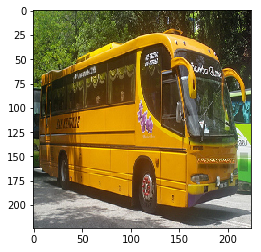

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(np.asarray(x_train[890], dtype='uint8'))

In [18]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.callbacks import EarlyStopping, ModelCheckpoint
from utils.custom_keras_callbacks import ModelCheckpointEveryNBatch

from models import vgg

from utils.losses import maad_from_deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


class BiternionCNN:
    
    def __init__(self,
                 input_shape=[224, 224, 3],
                 debug=False,
                 loss_type='cosine',
                 learning_rate=1.0e-4, 
                 fixed_kappa=1.0):
        
        self.loss_type = loss_type
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
        if debug:
            x_in = Input(shape=input_shape)
            x = Flatten(input_shape=input_shape)(x_in)
            x = Dense(128, activation='relu')(x)
        else:
            backbone_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                                               input_shape=input_shape)

            x = backbone_model.output
            x = GlobalAveragePooling2D()(x)    
    
        x = Dense(1024, activation='relu')(x)
        x = Dense(1024, activation='relu')(x)
    
        az_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='az_mean')(Dense(2, activation='linear')(x))
        az_kappa = Lambda(lambda x: K.abs(x), name='az_kappa')(Dense(1, activation='linear')(x))
        el_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='el_mean')(Dense(2, activation='linear')(x))
        el_kappa = Lambda(lambda x: K.abs(x), name='el_kappa')(Dense(1, activation='linear')(x))
        ti_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='ti_mean')(Dense(2, activation='linear')(x))
        ti_kappa = Lambda(lambda x: K.abs(x), name='ti_kappa')(Dense(1, activation='linear')(x))   
    
        y_pred = concatenate([az_mean, az_kappa, el_mean, el_kappa, ti_mean, ti_kappa])
        
        if debug:
            self.model = Model(x_in, y_pred, name='bi')
        else:    
            self.model = Model(backbone_model.input, y_pred, name='BiternionInception')
        
        opt = Adam(lr=learning_rate)
        self.model.compile(optimizer=opt, loss=self.loss)
        
    def unpack_preds(self, y_pred):
        
        az_mean = y_pred[:, 0:2]
        az_kappa =  y_pred[:, 2:3]
        
        el_mean = y_pred[:, 3:5]
        el_kappa = y_pred[:, 5:6]
        
        ti_mean = y_pred[:, 6:8]
        ti_kappa = y_pred[:, 8:9]
        
        return az_mean, az_kappa, el_mean, el_kappa, ti_mean, ti_kappa
    
    def unpack_target(self, y_target):
        
        az_target = y_target[:, 0:2]
        el_target = y_target[:, 2:4]
        ti_target = y_target[:, 4:6]
        
        return az_target, el_target, ti_target
    
    def loss(self, y_target, y_pred):
        
        az_mean, az_kappa, el_mean, el_kappa, ti_mean, ti_kappa = self.unpack_preds(y_pred)
        az_target, el_target, ti_target = self.unpack_target(y_target)
        
        if self.loss_type=='cosine':
            az_loss = cosine_loss_tf(az_target, az_mean)
            el_loss = cosine_loss_tf(el_target, el_mean)
            ti_loss = cosine_loss_tf(ti_target, ti_mean)
            
        elif self.loss_type=='likelihood':
            az_loss = -von_mises_log_likelihood_tf(az_target, az_mean, az_kappa)
            el_loss = -von_mises_log_likelihood_tf(el_target, el_mean, el_kappa)
            ti_loss = -von_mises_log_likelihood_tf(ti_target, ti_mean, ti_kappa)
            
        return az_loss + el_loss + ti_loss
    
    def fit(self, x, y, validation_data, ckpt_path, epochs=1, batch_size=32):
        
        early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
        model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', 
                                                     verbose=1, save_best_only=True, 
                                                     save_weights_only=True)
        
        self.model.fit(x, y, validation_data=validation_data,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stop_cb, model_ckpt])

In [19]:
K.clear_session()
bicnn_cosine = BiternionCNN(input_shape=x_train.shape[1:], debug=False)

In [ ]:
bicnn_cosine.fit(x_train, y_train, [x_val, y_val], epochs=50, ckpt_path='../logs/bicnn_debug.h5')

Train on 26900 samples, validate on 6725 samples
Epoch 1/50
26900/26900 [==============================] - 1358s 50ms/step - loss: 0.5530 - val_loss: 0.5456

Epoch 00001: val_loss improved from inf to 0.54563, saving model to ../logs/bicnn_debug.h5
Epoch 2/50
26900/26900 [==============================] - 1337s 50ms/step - loss: 0.5147 - val_loss: 0.5616

Epoch 00002: val_loss did not improve
Epoch 3/50
26900/26900 [==============================] - 1339s 50ms/step - loss: 0.4936 - val_loss: 0.4892

Epoch 00003: val_loss improved from 0.54563 to 0.48915, saving model to ../logs/bicnn_debug.h5
Epoch 4/50
26900/26900 [==============================] - 1337s 50ms/step - loss: 0.4820 - val_loss: 0.5245

Epoch 00004: val_loss did not improve
Epoch 5/50
22048/26900 [=======================>......] - ETA: 3:44 - loss: 0.4850